## Satellite Image Chronology Prediction Using ConvLSTM for Sequence Modeling

### 1. Importing Libraries

In [1]:
import numpy as np
from PIL import Image
import os
import time
import glob
from PIL import *
import skimage
import cv2
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, MaxPooling2D, Dense, Flatten, GRU, Conv2D, Reshape, Permute, Lambda, Input, SimpleRNN, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential, load_model, Model
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras import backend as K
import pylab as pl
import time
from keras import optimizers
from skimage.transform import resize
from skimage.io import imread

### 2. Defining constants and variables

In [2]:
WIDTH = 100
HEIGHT = 100
SEQUENCE = np.array([])
BASIC_SEQUENCE = np.array([])
NEXT_SEQUENCE = np.array([])
NUMBER = 0

### 3. Image Preprocessing

In [3]:
def image_initialize(image):
    picture = Image.open(image)
    picture = picture.resize((WIDTH, HEIGHT), Image.Resampling.LANCZOS)  
    picture = picture.convert('L')  
    data = np.array(picture).reshape(WIDTH, HEIGHT, 1)
    return data

for file in glob.glob('draper-satellite-image-chronology/train_sm/train_sm/set4_*.jpeg'):  
    image_array = (image_initialize(file)) / 255
    SEQUENCE = np.append(SEQUENCE, image_array)
    NUMBER += 1
    print(f"Processed {NUMBER} images.")

Processed 1 images.
Processed 2 images.
Processed 3 images.
Processed 4 images.
Processed 5 images.


### 4. Saving and Loading Data

In [4]:
SEQUENCE = SEQUENCE.reshape(NUMBER, WIDTH * HEIGHT)
np.savez('./sequence_array.npz', sequence_array=SEQUENCE)
print('Data saved.')

SEQUENCE = np.load('./sequence_array.npz')['sequence_array']

Data saved.


### 5. Preparing Training Data

In [5]:
n_samples = len(SEQUENCE)
n_frames = 1  

SEQUENCE = SEQUENCE.reshape(n_samples, WIDTH, HEIGHT, 1)
BASIC_SEQUENCE = np.zeros((n_samples - n_frames, n_frames, WIDTH, HEIGHT, 1))
NEXT_SEQUENCE = np.zeros((n_samples - n_frames, n_frames, WIDTH, HEIGHT, 1))

for i in range(n_frames):
    BASIC_SEQUENCE[:, i, :, :, :] = SEQUENCE[i:i + n_samples - n_frames]
    NEXT_SEQUENCE[:, i, :, :, :] = SEQUENCE[i + 1:i + n_samples - n_frames + 1]

### 6. Defining Custom Functions for SSIM, PSNR, MSE and RMSE

In [6]:
def ssim_loss(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * tf.keras.backend.log((max_pixel ** 2) / (tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true), axis=-1)))) / 2.303

def MSE(img1, img2):
    squared_diff = (img2 - img1) ** 2
    summed = np.sum(squared_diff)
    num_pix = img1.shape[0] * img1.shape[1]
    err = summed / num_pix
    return err

def RMSE(img1, img2):
    squared_diff = (img2 - img1) ** 2
    summed = np.sum(squared_diff)
    num_pix = img1.shape[0] * img1.shape[1]
    err = math.sqrt(summed / num_pix)
    return err

### 7. ConvLSTM2D Model

In [7]:
model = Sequential()
model.add(ConvLSTM2D(filters=256, kernel_size=(3, 3), input_shape=(None, WIDTH, HEIGHT, 1), 
                     padding="same", return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True))
model.add(BatchNormalization())
model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation="relu", padding='same', data_format="channels_last"))

model.compile(loss=ssim_loss, optimizer="adadelta", metrics=[
    tf.keras.metrics.MeanSquaredError(),
    tf.keras.metrics.RootMeanSquaredError(),
    ssim_loss,
    psnr
])

C:\Users\Sri Lakshmi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.summary()

training_fraction = 1.0
train_size = round(n_samples * training_fraction)

H = model.fit(BASIC_SEQUENCE[:train_size], NEXT_SEQUENCE[:train_size], verbose=2, epochs=10, batch_size=2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, None, 100, 100, │     2,369,536 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 100, 100, │         1,024 │
│ (BatchNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, None, 100, 100, │     4,719,616 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 100, 100, │         1,024 │
│ (BatchNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, None, 100, 100, │         6,913 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,098,113 (27.08 MB)

 Trainable params: 7,097,089 (27.07 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/10
2/2 - 9s - 4s/step - loss: 0.0154 - mean_squared_error: 0.1846 - psnr: 9.3130 - root_mean_squared_error: 0.4296 - ssim_loss: 0.0154
Epoch 2/10
2/2 - 8s - 4s/step - loss: 0.0149 - mean_squared_error: 0.1833 - psnr: 9.3702 - root_mean_squared_error: 0.4281 - ssim_loss: 0.0149
Epoch 3/10
2/2 - 10s - 5s/step - loss: 0.0149 - mean_squared_error: 0.1829 - psnr: 9.3894 - root_mean_squared_error: 0.4277 - ssim_loss: 0.0149
Epoch 4/10
2/2 - 10s - 5s/step - loss: 0.0149 - mean_squared_error: 0.1835 - psnr: 9.3670 - root_mean_squared_error: 0.4283 - ssim_loss: 0.0149
Epoch 5/10
2/2 - 8s - 4s/step - loss: 0.0147 - mean_squared_error: 0.1828 - psnr: 9.3914 - root_mean_squared_error: 0.4275 - ssim_loss: 0.0147
Epoch 6/10
2/2 - 6s - 3s/step - loss: 0.0147 - mean_squared_error: 0.1829 - psnr: 9.3884 - root_mean_squared_error: 0.4277 - ssim_loss: 0.0147
Epoch 7/10
2/2 - 7s - 3s/step - loss: 0.0146 - mean_squared_error: 0.1830 - psnr: 9.3861 - root_mean_squared_error: 0.4278 - ssim_loss: 0.01

In [13]:
model.save('conv_lstm.h5')

### 8. Testing the Model

In [9]:
index = 1
num_test_frames = 0

train_pred = BASIC_SEQUENCE[index][:n_frames - num_test_frames, :, :, :]
for j in range(n_frames):
    new_pos = model.predict(train_pred[np.newaxis, :, :, :, :])
    new = new_pos[:, -1, :, :, :]
    train_pred = np.concatenate((train_pred, new), axis=0)

truth = BASIC_SEQUENCE[index][:, :, :, :]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


### 9. Visualization

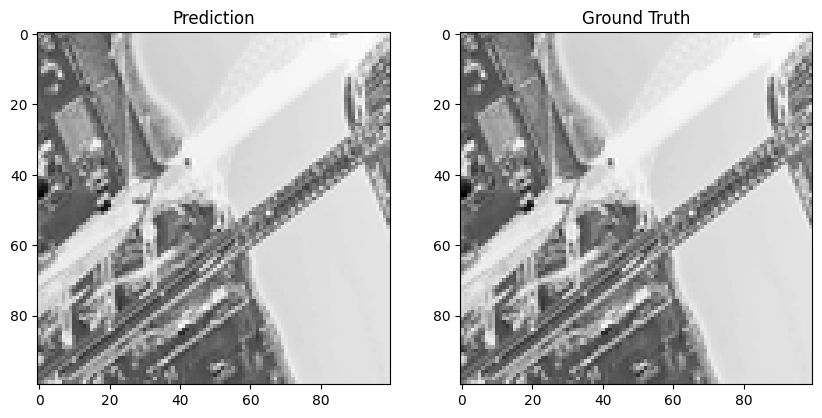

In [10]:
for i in range(n_frames):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.title("Prediction")
    pred = train_pred[i, :, :, 0]
    plt.imshow(pred, cmap='binary')
    plt.savefig(f'{i + 1}_Prediction.png')

    plt.subplot(122)
    plt.title("Ground Truth")
    gt = truth[i, :, :, 0]
    plt.imshow(gt, cmap='binary')
    plt.savefig(f'{i + 1}_GroundTruth.png')

### 10. Evaluation

In [16]:
imageA = cv2.imread('./1_Prediction.png')
imageB = cv2.imread('./1_GroundTruth.png')

if imageA is None or imageB is None:
    print("Error: One or both images could not be loaded. Check file paths.")
else:
    imageA_gray = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    imageB_gray = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

    (score, _) = ssim(imageA_gray, imageB_gray, full=True)
    print("SSIM:", score)

    mse_score = MSE(imageA_gray, imageB_gray)
    rmse_score = RMSE(imageA_gray, imageB_gray)

    print("MSE:", mse_score)
    print("RMSE:", rmse_score)

SSIM: 0.8009972709210607
MSE: 27.060864
RMSE: 5.20200576700949


### Inference from the Evaluation Metrics:

**Structural Similarity Index (SSIM):**
1. The SSIM score of 0.801 (out of 1.0) indicates a good structural similarity between the predicted image and the ground truth.
2. While it's not perfect, it suggests that the model has preserved most of the structural details.

**Mean Squared Error (MSE):**
1. The MSE value of 27.06 indicates the average squared difference between the pixel intensities of the two images.
2. A lower MSE value is better; however, this value suggests some noticeable differences between the images.

**Root Mean Squared Error (RMSE):**
1. The RMSE value of 5.20 represents the standard deviation of the prediction errors.
2. It shows the typical difference in pixel values, where lower values indicate a closer match.

**Summary:** The model is performing reasonably well, with good structural similarity (high SSIM) but has room for improvement in pixel-level accuracy (indicated by MSE and RMSE).

### 11. Visualization of metrics

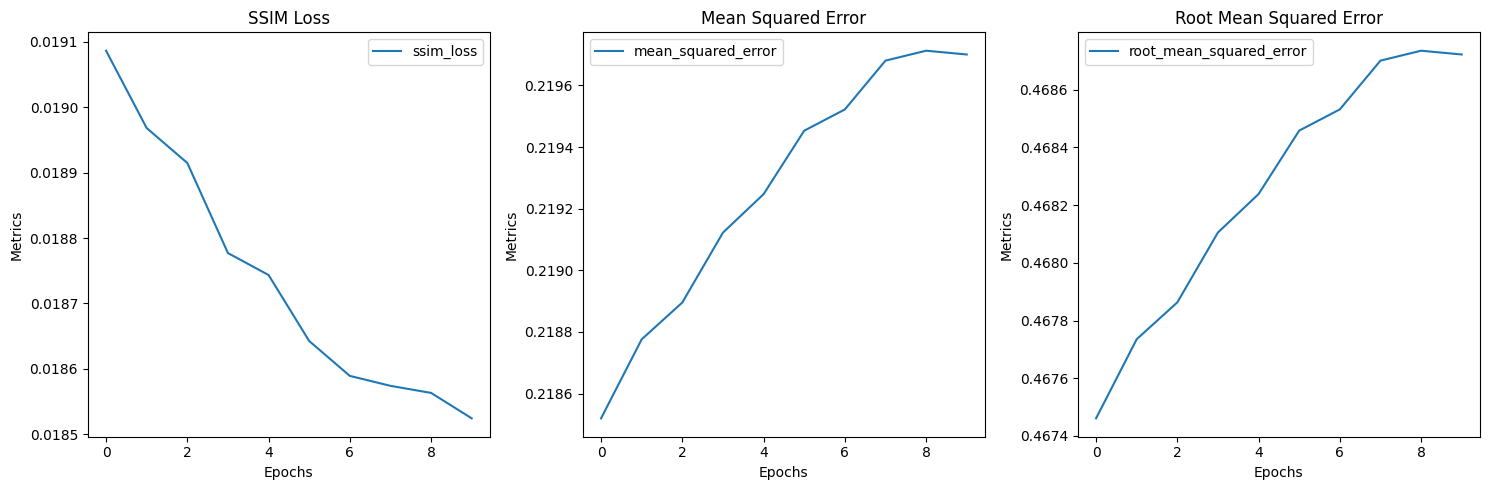

In [17]:
plt.figure(figsize=(15, 5))

# SSIM Loss Plot
plt.subplot(1, 3, 1)
plt.plot(H.history['ssim_loss'])
plt.title('SSIM Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['ssim_loss'])

# Mean Squared Error Plot
plt.subplot(1, 3, 2)
plt.plot(H.history['mean_squared_error'])
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['mean_squared_error'])

# Root Mean Squared Error Plot
plt.subplot(1, 3, 3)
plt.plot(H.history['root_mean_squared_error'])
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['root_mean_squared_error'])

plt.tight_layout()
plt.show()

### 12. U - net model

In [20]:
def unet_model(input_shape=(100, 100, 1)):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    
    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = concatenate([up4, conv2], axis=-1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv1], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

unet = unet_model()
unet.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 100, 100, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 100, 100, 64)      │             640 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_13 (Conv2D)            │ (None, 100, 100, 64)      │          36,928 │ conv2d_12[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 50, 50, 64)        │               0 │ conv2d_13[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_14 (Conv2D)            │ (None, 50, 50, 128)       │          73,856 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_15 (Conv2D)            │ (None, 50, 50, 128)       │         147,584 │ conv2d_14[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 25, 25, 128)       │               0 │ conv2d_15[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_16 (Conv2D)            │ (None, 25, 25, 256)       │         295,168 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_17 (Conv2D)            │ (None, 25, 25, 256)       │         590,080 │ conv2d_16[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 50, 50, 256)       │               0 │ conv2d_17[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 50, 50, 384)       │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ conv2d_15[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_18 (Conv2D)            │ (None, 50, 50, 128)       │         442,496 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_19 (Conv2D)            │ (None, 50, 50, 128)       │         147,584 │ conv2d_18[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 100, 100, 128)     │               0 │ conv2d_19[0][0]            │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 100, 100, 192)     │               0 │ up_sampling2d_1[0][0],     │
│                               │                           │               

 Total params: 1,881,985 (7.18 MB)

 Trainable params: 1,881,985 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
print(f"BASIC_SEQUENCE shape: {BASIC_SEQUENCE.shape}")
print(f"NEXT_SEQUENCE shape: {NEXT_SEQUENCE.shape}")

BASIC_SEQUENCE = BASIC_SEQUENCE.reshape(-1, 100, 100, 1) / 255.0
NEXT_SEQUENCE = NEXT_SEQUENCE.reshape(-1, 100, 100, 1) / 255.0

BASIC_SEQUENCE shape: (4, 1, 100, 100, 1)
NEXT_SEQUENCE shape: (4, 1, 100, 100, 1)


### 13. Training the model

In [22]:
from tensorflow.keras.callbacks import LambdaCallback

log_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1} - Logs: {logs}")
)

U = unet.fit(
    BASIC_SEQUENCE, NEXT_SEQUENCE, 
    batch_size=2, epochs=10, verbose=2, 
    callbacks=[log_callback]
)

Epoch 1/10


C:\Users\Sri Lakshmi\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_43']
Received: inputs=Tensor(shape=(2, 100, 100, 1))
  warnings.warn(msg)


Epoch 1 - Logs: {'loss': 0.24707680940628052, 'mean_squared_error': 0.24707680940628052}
2/2 - 4s - 2s/step - loss: 0.2471 - mean_squared_error: 0.2471
Epoch 2/10
Epoch 2 - Logs: {'loss': 0.2298162579536438, 'mean_squared_error': 0.2298162579536438}
2/2 - 1s - 719ms/step - loss: 0.2298 - mean_squared_error: 0.2298
Epoch 3/10
Epoch 3 - Logs: {'loss': 0.08345870673656464, 'mean_squared_error': 0.08345870673656464}
2/2 - 1s - 700ms/step - loss: 0.0835 - mean_squared_error: 0.0835
Epoch 4/10
Epoch 4 - Logs: {'loss': 0.00018964092305395752, 'mean_squared_error': 0.00018964092305395752}
2/2 - 1s - 430ms/step - loss: 1.8964e-04 - mean_squared_error: 1.8964e-04
Epoch 5/10
Epoch 5 - Logs: {'loss': 3.838968041236512e-06, 'mean_squared_error': 3.838968495983863e-06}
2/2 - 2s - 780ms/step - loss: 3.8390e-06 - mean_squared_error: 3.8390e-06
Epoch 6/10
Epoch 6 - Logs: {'loss': 3.8368848436221015e-06, 'mean_squared_error': 3.8368848436221015e-06}
2/2 - 1s - 685ms/step - loss: 3.8369e-06 - mean_square

In [23]:
unet.save('unet.h5')

In [24]:
test_image = BASIC_SEQUENCE[0]  
test_image = np.expand_dims(test_image, axis=0)  

predicted_image = unet.predict(test_image)
ground_truth = NEXT_SEQUENCE[0]

print("Ground Truth Shape:", ground_truth.shape)
print("Predicted Image Shape:", predicted_image.shape)

# Checking if the shapes of the two images match
if ground_truth.shape != predicted_image.shape:
    print("Shapes are different, resizing predicted image to match ground truth shape.")
    if len(ground_truth.shape) == 3:  # If ground_truth is (height, width, 1)
        ground_truth = np.squeeze(ground_truth, axis=-1)  # Removing channel dimension
    if len(predicted_image.shape) == 4:  # If predicted_image is (1, height, width, 1)
        predicted_image = np.squeeze(predicted_image, axis=0)  # Removing batch dimension
    
    # Printing shapes after squeezing to confirm correct dimensions
    print("Resized Ground Truth Shape:", ground_truth.shape)
    print("Resized Predicted Image Shape:", predicted_image.shape)
    
    # Resizing predicted image to match ground truth
    predicted_image = cv2.resize(predicted_image, (ground_truth.shape[1], ground_truth.shape[0]))

# Ensuring that predicted_image has the correct shape (height, width)
if len(predicted_image.shape) == 4:  # If predicted_image is (batch_size, height, width, channels)
    predicted_image = np.squeeze(predicted_image, axis=0)  

# Ensuring that ground_truth has the correct shape (height, width)
if len(ground_truth.shape) == 3:  # If the shape is (height, width, 1)
    ground_truth = np.squeeze(ground_truth, axis=-1)  

C:\Users\Sri Lakshmi\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_43']
Received: inputs=Tensor(shape=(1, 100, 100, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Ground Truth Shape: (100, 100, 1)
Predicted Image Shape: (1, 100, 100, 1)
Shapes are different, resizing predicted image to match ground truth shape.
Resized Ground Truth Shape: (100, 100)
Resized Predicted Image Shape: (100, 100, 1)


In [25]:
data_range = 1.0 

ssim_value = ssim(ground_truth, predicted_image, data_range=data_range)
mse_value = np.mean((ground_truth - predicted_image) ** 2)
rmse_value = np.sqrt(mse_value)

print("SSIM:", ssim_value)
print("MSE:", mse_value)
print("RMSE:", rmse_value)

SSIM: 0.964374217061777
MSE: 3.7924595588512446e-06
RMSE: 0.0019474238261999479


### 14. Convolutional Autoencoder model

In [26]:
def autoencoder_model(input_shape=(100, 100, 1)):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    
    # Decoder
    up1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(bottleneck)
    up2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(up1)
    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=ssim_loss, metrics=['mse', 'mae', ssim_loss, psnr])
    
    return model

autoencoder = autoencoder_model()
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100, 100, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 100, 100, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 50, 50, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 100, 100, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 100, 100, 1)         │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 739,073 (2.82 MB)

 Trainable params: 739,073 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
A = autoencoder.fit(BASIC_SEQUENCE, NEXT_SEQUENCE, batch_size=2, epochs=10, verbose=2)

Epoch 1/10


C:\Users\Sri Lakshmi\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_61']
Received: inputs=Tensor(shape=(2, 100, 100, 1))
  warnings.warn(msg)


2/2 - 3s - 1s/step - loss: 0.0081 - mae: 0.4988 - mse: 0.2488 - psnr: 6.0410 - ssim_loss: 0.0081
Epoch 2/10
2/2 - 0s - 109ms/step - loss: 0.0080 - mae: 0.5018 - mse: 0.2518 - psnr: 5.9879 - ssim_loss: 0.0080
Epoch 3/10
2/2 - 0s - 111ms/step - loss: 0.0079 - mae: 0.5057 - mse: 0.2557 - psnr: 5.9218 - ssim_loss: 0.0079
Epoch 4/10
2/2 - 0s - 108ms/step - loss: 0.0079 - mae: 0.5106 - mse: 0.2607 - psnr: 5.8377 - ssim_loss: 0.0079
Epoch 5/10
2/2 - 0s - 231ms/step - loss: 0.0077 - mae: 0.5171 - mse: 0.2674 - psnr: 5.7278 - ssim_loss: 0.0077
Epoch 6/10
2/2 - 0s - 144ms/step - loss: 0.0075 - mae: 0.5259 - mse: 0.2766 - psnr: 5.5810 - ssim_loss: 0.0075
Epoch 7/10
2/2 - 0s - 124ms/step - loss: 0.0068 - mae: 0.5384 - mse: 0.2900 - psnr: 5.3778 - ssim_loss: 0.0068
Epoch 8/10
2/2 - 0s - 138ms/step - loss: 0.0047 - mae: 0.5585 - mse: 0.3125 - psnr: 5.0655 - ssim_loss: 0.0047
Epoch 9/10
2/2 - 0s - 202ms/step - loss: 0.0017 - mae: 0.5981 - mse: 0.3608 - psnr: 4.5018 - ssim_loss: 0.0017
Epoch 10/10
2/2

In [28]:
autoencoder.save('autoencoder.h5')

In [32]:
if predicted_image.max() <= 1:
    predicted_image = np.clip(predicted_image * 255, 0, 255).astype(np.uint8)

if ground_truth.max() <= 1:
    ground_truth = np.clip(ground_truth * 255, 0, 255).astype(np.uint8)

if predicted_image.shape != ground_truth.shape:
    ground_truth = cv2.resize(ground_truth, (predicted_image.shape[1], predicted_image.shape[0]))

predicted_image = np.float32(predicted_image)
ground_truth = np.float32(ground_truth)

In [33]:
ssim_value = tf.image.ssim(ground_truth, predicted_image, max_val=255).numpy()
mse_value = np.mean((ground_truth - predicted_image) ** 2)
rmse_value = np.sqrt(mse_value)

print("SSIM:", ssim_value)
print("MSE:", mse_value)
print("RMSE:", rmse_value)

SSIM: 1.0
MSE: 0.0
RMSE: 0.0
